_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 96, 128, 16)       80        
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 48, 64, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 48, 64, 64)        4160      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 24, 32, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 24, 32, 128)       32896     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 12, 16, 128)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 24576)             0         
__________

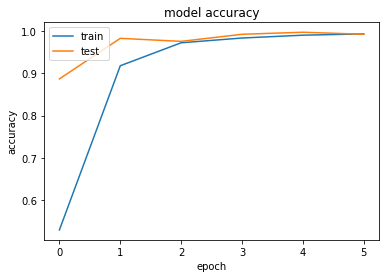

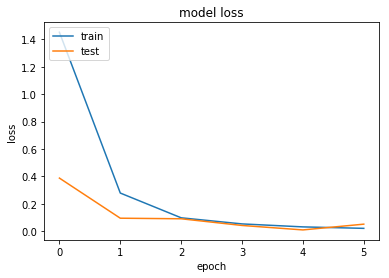

Score log_loss:  0.0172249404684


In [66]:
from sklearn.datasets import load_files
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import numpy as np
from glob import glob
import random
import cv2
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt     
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import log_loss
import math
import pickle
import os
import pandas as pd
import datetime

def model_history(history):
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def create_submission(predictions, test_id, loss):
    print('Started building csv file')
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.insert(loc=0, column='img', value=test_id)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = str(round(loss, 6)) + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)
    print("successfully created submission")   
    
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()

def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

def read_imc(path):
    # Load as grayscale
    #img = cv2.imread(path, 0)
    # Reduce size
    #resized = cv2.resize(img, (224, 224))
    #x = image.img_to_array(path)
    #resized=np.expand_dims(x, axis=0)
    img = cv2.imread(path,0)
    img_rows, img_cols=96,128
   # resized = cv2.resize(img, (96, 128), cv2.INTER_LINEAR)
    resized = cv2.resize(img, (img_rows, img_cols))
    return resized


def load_train():
    #path='Data/imgs/train'
    #data=load_files(path)
    #driver_file=np.array(data['filenames'])
    #driver_target=np_utils.to_categorical(np.array(data['target']),10)
    #data=glob(path)
    driver_file=[]
    driver_target=[]
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join( 'Data', 'imgs', 'train', 'c' + str(j), '*.jpg')
        data = glob(path)
        for p in data:
            driver_file.append(read_imc(p))
            driver_target.append(j)
        
    return driver_file,driver_target

def load_test():
    path='Data/imgs/test/*'
    data=glob(path)
    driver_file=[]
    driver_id=[]  
    for p in data:
        driver_file.append(read_imc(p))
        driver_id.append(os.path.basename(p))
   # driver_id=os.path.basename(p)
    #test_id=np.array(driver_file['target'])
    return driver_file,driver_id


def print_sample(data,target):
    print ("X shape",data.shape) 
    print ("Y shape",target.shape)
    
   # for p in data[:2]: print (p)
  #  for p in target[:2]: print (p)
    #im = cv2.imread(data[1])
    # show sample image   
    #plt.imshow(im)
    #plt.show()
    return None

img_rows=96
img_cols=128
img_channel=1  

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(img_rows, img_cols, img_channel)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])




cache_path= os.path.join('cache','test.dat')
if not os.path.isfile(cache_path):
    print('building test cache')
    test_files,test_id = load_test()
    cache_data((test_files,test_id),cache_path)
    print('test cache built')
else:
    print('Restore test from cache')
    (test_files,test_id)=restore_data(cache_path)

    
#test_files=test_files[:100]
#test_id=test_id[:100]
test_files=np.array(test_files,dtype=np.uint8)
test_files = test_files.reshape(test_files.shape[0], img_rows, img_cols,img_channel)
#test_files=test_files[:1000]
#test_id=test_id[:1000]


#submission training set
cache_path= os.path.join('cache','train.dat')
if not os.path.isfile(cache_path):
    print('building train cache')
    train_files,train_targets = load_train()
    cache_data((train_files,train_targets),cache_path)
    print('train cache built')           
else:
    print('Restore train from cache')
    (train_files,train_targets)=restore_data(cache_path)

#print_sample(train_files,train_targets)
# pre-process the data for Keras
#img_rows, img_cols ,img_channel=  224, 224,3


train_files=np.array(train_files,dtype=np.uint8)
train_targets=np.array(train_targets,dtype=np.uint8)
#has no shape
train_files = train_files.reshape(train_files.shape[0], img_rows, img_cols,img_channel)

train_targets=np_utils.to_categorical(train_targets,10)
# My own test set - split the training set 
X_train, X_split, y_train, y_split = train_test_split(train_files,train_targets ,test_size=0.2,random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_split,y_split ,test_size=0.3,random_state=42)
#print('Dataset shape'.train_files.shape)
print('Train shape',X_train.shape )
print('Test shape',X_test.shape )
print('Val shape',X_val.shape )
train_datagen=ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last')

val_datagen=ImageDataGenerator(
    rescale=1./255,
    data_format='channels_last')

train_datagen.fit(X_train)
val_datagen.fit(X_val)

### TODO: Define your architecture.


#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
checkpointer = ModelCheckpoint(filepath='saved_models/weightsfromscratch.hdf5', 
                               verbose=1, save_best_only=True)
epochs=6
batch_size=100
history=model.fit_generator(train_datagen.flow(X_train,y_train,batch_size=batch_size),
                            validation_data=val_datagen.flow(X_val,y_val),
                    steps_per_epoch=len(X_train)//batch_size,validation_steps=len(X_val)//batch_size,epochs=epochs,
                            callbacks=[checkpointer],verbose=0)
model_history(history)


model.load_weights('saved_models/weightsfromscratch.hdf5')
#score = model.evaluate(X_test, y_test, verbose=1)
#print(score)


X_test = X_test.astype('float32')
X_test/=255
predictions=model.predict(X_test, verbose=0)
score=log_loss(y_test,predictions)
print('Score log_loss: ', score)
      

In [67]:
test_files = test_files.astype('float32')
test_files/=255
predictions=model.predict(test_files,  batch_size=batch_size)
create_submission(predictions,test_id,score)

Started building csv file
successfully created submission
